In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import numpy as np
from numpy import genfromtxt
from tensorflow import keras
from sklearn import preprocessing
from sklearn.decomposition import PCA
from scipy.interpolate import CubicSpline
import keras.backend as K
import math
import tensorflow as tf
from tensorflow import keras
from statsmodels.nonparametric.smoothers_lowess import lowess
from tensorflow.keras import layers



state_dat_est=[]
state_dat_ref=[]
par_dat_est=[]
num_parameters=9
sampling_fact=30;  # defining factor
Fs=sampling_fact
Keta=0
horizon=5


trans='approximator3.h5'
deformy='deformer.h5'

my_model_p = keras.models.load_model(trans)
my_model = keras.models.load_model(deformy)


for i in range(horizon):
    # Get States Data
    X_Dat=[]
    daty = genfromtxt("D:\Research_work\COVID_paper\My_covid_research\dataset_preprocessing\parameter_estim\input_new\states_ "+str(i)+" .csv", delimiter=',')
    days=daty[:,0]
    S=daty[:,1]
    I=daty[:,2]
    Q=daty[:,3]
    R=daty[:,4]
    D=daty[:,5]
    
    init_cond=[S[0],I[0],Q[0],R[0],D[0]]

    S_ref=S
    I_ref=I
    Q_ref=Q
    R_ref=R
    D_ref=D

    

    
    days_n=np.linspace(0,days[len(days)-1],len(days)*sampling_fact)

    c_S = CubicSpline(days,S)
    cubic_S=c_S(days_n)

    c_I = CubicSpline(days,I)
    cubic_I=c_I(days_n)

    c_Q = CubicSpline(days,Q)
    cubic_Q=c_Q(days_n)

    c_R = CubicSpline(days,D)
    cubic_R=c_R(days_n)

    c_D = CubicSpline(days,D)
    cubic_D=c_D(days_n)


    cubic_S=cubic_S[0:81]
    cubic_I=cubic_I[0:81]
    cubic_Q=cubic_Q[0:81]
    cubic_R=cubic_R[0:81]
    cubic_D=cubic_D[0:81]


    nc=1
    S = np.reshape(cubic_S, (-1, 9))
    pca = PCA(n_components=nc)
    S_new= pca.fit_transform(S).flatten()
    S_new=np.expand_dims(S_new, axis=0)

    I = np.reshape(cubic_I, (-1, 9))
    pca = PCA(n_components=nc)
    I_new= pca.fit_transform(I).flatten()
    I_new=np.expand_dims(I_new, axis=0)
    
    Q= np.reshape(cubic_Q, (-1, 9))
    pca = PCA(n_components=nc)
    Q_new= pca.fit_transform(Q).flatten()
    Q_new=np.expand_dims(Q_new, axis=0)

    R= np.reshape(cubic_R, (-1, 9))
    pca = PCA(n_components=nc)
    R_new= pca.fit_transform(R).flatten() 
    R_new=np.expand_dims(R_new, axis=0)

    D= np.reshape(cubic_D, (-1, 9))
    pca = PCA(n_components=nc)
    D_new= pca.fit_transform(D).flatten() 
    D_new=np.expand_dims(D_new, axis=0)

    my_dat=np.concatenate((np.transpose(S_new),np.transpose(I_new),np.transpose(Q_new),np.transpose(R_new),np.transpose(D_new)),axis=1)
    #----------------------------------------------------------------------------------------------------------------------
    #----------------------------------------------------------------------------------------------------------------------
    #Dimensions should be time x channels
    X_Dat.append(my_dat)

    X_datnew=np.asarray(X_Dat)

    X=X_datnew

    out_p=my_model_p.predict(X)


    out_p_new=np.expand_dims(out_p, axis=2)
    
    out=my_model.predict(out_p_new)

    parameters=list(out[0])


    #Hybrid SIQRD model
    zeta=parameters[0]
    beta1=parameters[1]
    beta2=parameters[2]
    alpha1=parameters[3]
    alpha2=parameters[4]
    delta=parameters[5]
    Keta=parameters[6]
    to=parameters[7]
    gamma=parameters[8]



    N=sum(init_cond)



    def siqrd(states, t):

        S=states[0]
        I=states[1]
        Q=states[2]
        R=states[3]
        D=states[4]


        return [-zeta*(N-S)+gamma*R,
        zeta*(N-S)-beta1*(to-t)*I-beta2*I-Keta-delta*I,
        beta2*I+Keta-alpha2*Q-alpha1*Q,
        beta1*(to-t)*I+alpha1*Q-gamma*R,
        delta*I*D+alpha2*np.log(1+Q)]




    Fs=10
    days = np.linspace(0, 3, Fs*3)

    SIQRD = odeint(siqrd,init_cond,days)
    S= np.abs(SIQRD[::Fs,0])
    I = np.abs(SIQRD[::Fs,1])
    Q= np.abs(SIQRD[::Fs,2])
    R = np.abs(SIQRD[::Fs,3])
    D = np.abs(SIQRD[::Fs,4])
    days=days[::Fs]

    state_dater=np.stack((S,I,Q,R,D))
    state_dater=np.transpose(state_dater)

    state_rdater=np.stack((S_ref,I_ref,Q_ref,R_ref,D_ref))
    state_rdater=np.transpose(state_rdater)

    # para_dater=np.stack((alpha*np.ones(3),t1*np.ones(3),gamma1*np.ones(3),gamma2*np.ones(3),beta*np.ones(3)))
    # para_dater=np.stack((alpha*np.ones(3),beta*np.ones(3),gamma1*np.ones(3),gamma2*np.ones(3),delta*np.ones(3)))
    para_dater=np.stack((zeta*np.ones(3),beta1*np.ones(3),beta2*np.ones(3),alpha1*np.ones(3),alpha2*np.ones(3),delta*np.ones(3),Keta*np.ones(3),to*np.ones(3),gamma*np.ones(3)))
    para_dater=np.transpose(para_dater)


    state_dat_est.append(state_dater)
    state_dat_ref.append(state_rdater)
    par_dat_est.append(para_dater)




state_dat_est=np.vstack(state_dat_est)   
state_dat_ref=np.vstack(state_dat_ref)
par_dat_est=np.vstack(par_dat_est)

days=np.linspace(0,state_dat_est.shape[0]-1,state_dat_est.shape[0])

In [2]:
from scipy.signal import savgol_filter
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.nonparametric.smoothers_lowess import lowess


######defining factors##########
window_len=9
degree_poly=2
################
x=np.arange(0,15)

S=state_dat_est[:,0]
sig_S=np.squeeze(S)
S_sig=savgol_filter(sig_S,window_len,degree_poly)
S_sig=S_sig.reshape(-1,1)

I=state_dat_est[:,1]
sig_I=np.squeeze(I)
I_sig=savgol_filter(sig_I,window_len,degree_poly)
I_sig= lowess(I_sig, x, frac=1./1)
I_sig=I_sig[:,1]
I_sig=I_sig.reshape(-1,1)


Q=state_dat_est[:,2]
sig_Q=np.squeeze(Q)
Q_sig=savgol_filter(sig_Q,window_len,degree_poly)
Q_sig=Q_sig.reshape(-1,1)


R=state_dat_est[:,3]
sig_R=np.squeeze(R)
R_sig=savgol_filter(sig_R,window_len,degree_poly)
R_sig= lowess(R_sig, x, frac=1./5)
R_sig=R_sig[:,1]
R_sig=savgol_filter(R_sig,window_len,degree_poly)
R_sig=R_sig.reshape(-1,1)


D=state_dat_est[:,4]
sig_D=np.squeeze(D)
D_sig=savgol_filter(sig_D,window_len,degree_poly)
D_sig=savgol_filter(D_sig,window_len,degree_poly)
D_sig=D_sig.reshape(-1,1)



state_dat_est=np.hstack((S_sig,I_sig,Q_sig,R_sig,D_sig))

In [3]:
np.savetxt('future_data_ref.csv', state_dat_ref, delimiter=',')
np.savetxt('future_data_est.csv', state_dat_est, delimiter=',')

In [4]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
rms = mean_squared_error(state_dat_est, state_dat_ref, squared=False)
print("MAE: ",mean_absolute_error( state_dat_est, state_dat_ref))
print("RMSE: ",rms)
extender=15
days=np.linspace(1, extender, extender)

MAE:  68.09100024439864
RMSE:  84.71850720429318


In [5]:
from tkinter import font
from matplotlib import pyplot
import seaborn as sns
#read csv pd
extender=15
import pandas as pd


df=pd.read_excel('D:\Research_work\My_covid_research\dataset_preprocessing\Korea_dataset.xlsx')
df=df.sort_values(by=['DATE'], ascending=True)


dates=df['DATE'][0:df.index.max()-200-30-4].tolist()
# dates=dates.reverse()

dates=dates[-16:-1]
# reverse list
dates=dates[::-1]

df_ref = pd.DataFrame({'DATE': dates, "S": np.flip(np.round(state_dat_ref[0:extender,0],2)), "I":  np.flip(state_dat_ref[0:extender,1]), "Q":  np.flip(state_dat_ref[0:extender,2]), "R":  np.flip(state_dat_ref[0:extender,3]),"D":  np.flip(state_dat_ref[0:extender,4])})
df_ref.set_index('DATE', inplace=True)

df_est = pd.DataFrame({'DATE': dates, "S":  np.flip(np.round(state_dat_est[0:extender,0],2)), "I":  np.flip(state_dat_est[0:extender,1]), "Q":  np.flip(state_dat_est[0:extender,2]), "R":  np.flip(state_dat_est[0:extender,3]),"D":  np.flip(state_dat_est[0:extender,4])})
df_est.set_index('DATE', inplace=True)


sns.set_style('darkgrid')

pyplot.figure(figsize=(30, 10),dpi=500) # width and height in inches
ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)

g1=sns.lineplot(data=df_est, x="DATE", y="S",palette="flare", ax=ax1,label='Predicted',linewidth=5)
g1=sns.lineplot(data=df_ref, x="DATE", y="S", palette="flare", ax=ax1,label='Reference',color='black')
ax1.lines[1].set_linestyle("--")

g1.set(ylabel=None)
# g1.set(title="Susceptible (RMSE="+str(round(mean_squared_error(state_dat_est[0:extender,0], state_dat_ref[0:extender,0], squared=False),2))+")")
g1.set(title="(a)")
g1.set(ylim=(5.132e7,5.134e7))

g2=sns.lineplot(data=df_est, x="DATE", y="I",palette="flare", ax=ax2,label='Predicted',linewidth=5)
g2=sns.lineplot(data=df_ref, x="DATE", y="I", palette="flare", ax=ax2,label='Reference',color='black')
ax2.lines[1].set_linestyle("--")

g2.set(ylabel=None)
# g2.set(title="Infected (RMSE="+str(round(mean_squared_error(state_dat_est[0:extender,1], state_dat_ref[0:extender,1], squared=False),2))+")")
g2.set(title="(i)")

g3=sns.lineplot(data=df_est, x="DATE", y="Q",palette="flare", ax=ax3,label='Predicted',linewidth=5)
g3=sns.lineplot(data=df_ref, x="DATE", y="Q", palette="flare", ax=ax3,label='Reference',color='black')
ax3.lines[1].set_linestyle("--")

g3.set(ylabel=None)
# g3.set(title="Quarantined (RMSE="+str(round(mean_squared_error(state_dat_est[0:extender,2], state_dat_ref[0:extender,2], squared=False),2))+")")
g3.set(title="(c)")


g4=sns.lineplot(data=df_est, x="DATE", y="R",palette="flare", ax=ax4,label='Predicted',linewidth=5)
g4=sns.lineplot(data=df_ref, x="DATE", y="R", palette="flare", ax=ax4,label='Reference',color='black')
ax4.lines[1].set_linestyle("--")

g4.set(ylabel=None)
# g4.set(title="Recovered (RMSE="+str(round(mean_squared_error(state_dat_est[0:extender,3], state_dat_ref[0:extender,3], squared=False),2))+")")
g4.set(title="(d)")


g5=sns.lineplot(data=df_est, x="DATE", y="D",palette="flare", ax=ax5,label='Predicted',linewidth=5)
g5=sns.lineplot(data=df_ref, x="DATE", y="D", palette="flare", ax=ax5,label='Reference',color='black')
ax5.lines[1].set_linestyle("--")

g5.set(ylabel=None)
# g5.set(ylim=(0,1000))
g5.set(title="(e)")
# g5.set(title="Deceased (RMSE="+str(round(mean_squared_error(state_dat_est[0:extender,4], state_dat_ref[0:extender,4], squared=False),2))+")")

plt.show()

In [11]:
dates

[Timestamp('2021-07-18 00:00:00'),
 Timestamp('2021-07-17 00:00:00'),
 Timestamp('2021-07-16 00:00:00'),
 Timestamp('2021-07-15 00:00:00'),
 Timestamp('2021-07-14 00:00:00'),
 Timestamp('2021-07-13 00:00:00'),
 Timestamp('2021-07-12 00:00:00'),
 Timestamp('2021-07-11 00:00:00'),
 Timestamp('2021-07-10 00:00:00'),
 Timestamp('2021-07-09 00:00:00'),
 Timestamp('2021-07-08 00:00:00'),
 Timestamp('2021-07-07 00:00:00'),
 Timestamp('2021-07-06 00:00:00'),
 Timestamp('2021-07-05 00:00:00'),
 Timestamp('2021-07-04 00:00:00')]

[(51320000.0, 51340000.0)]

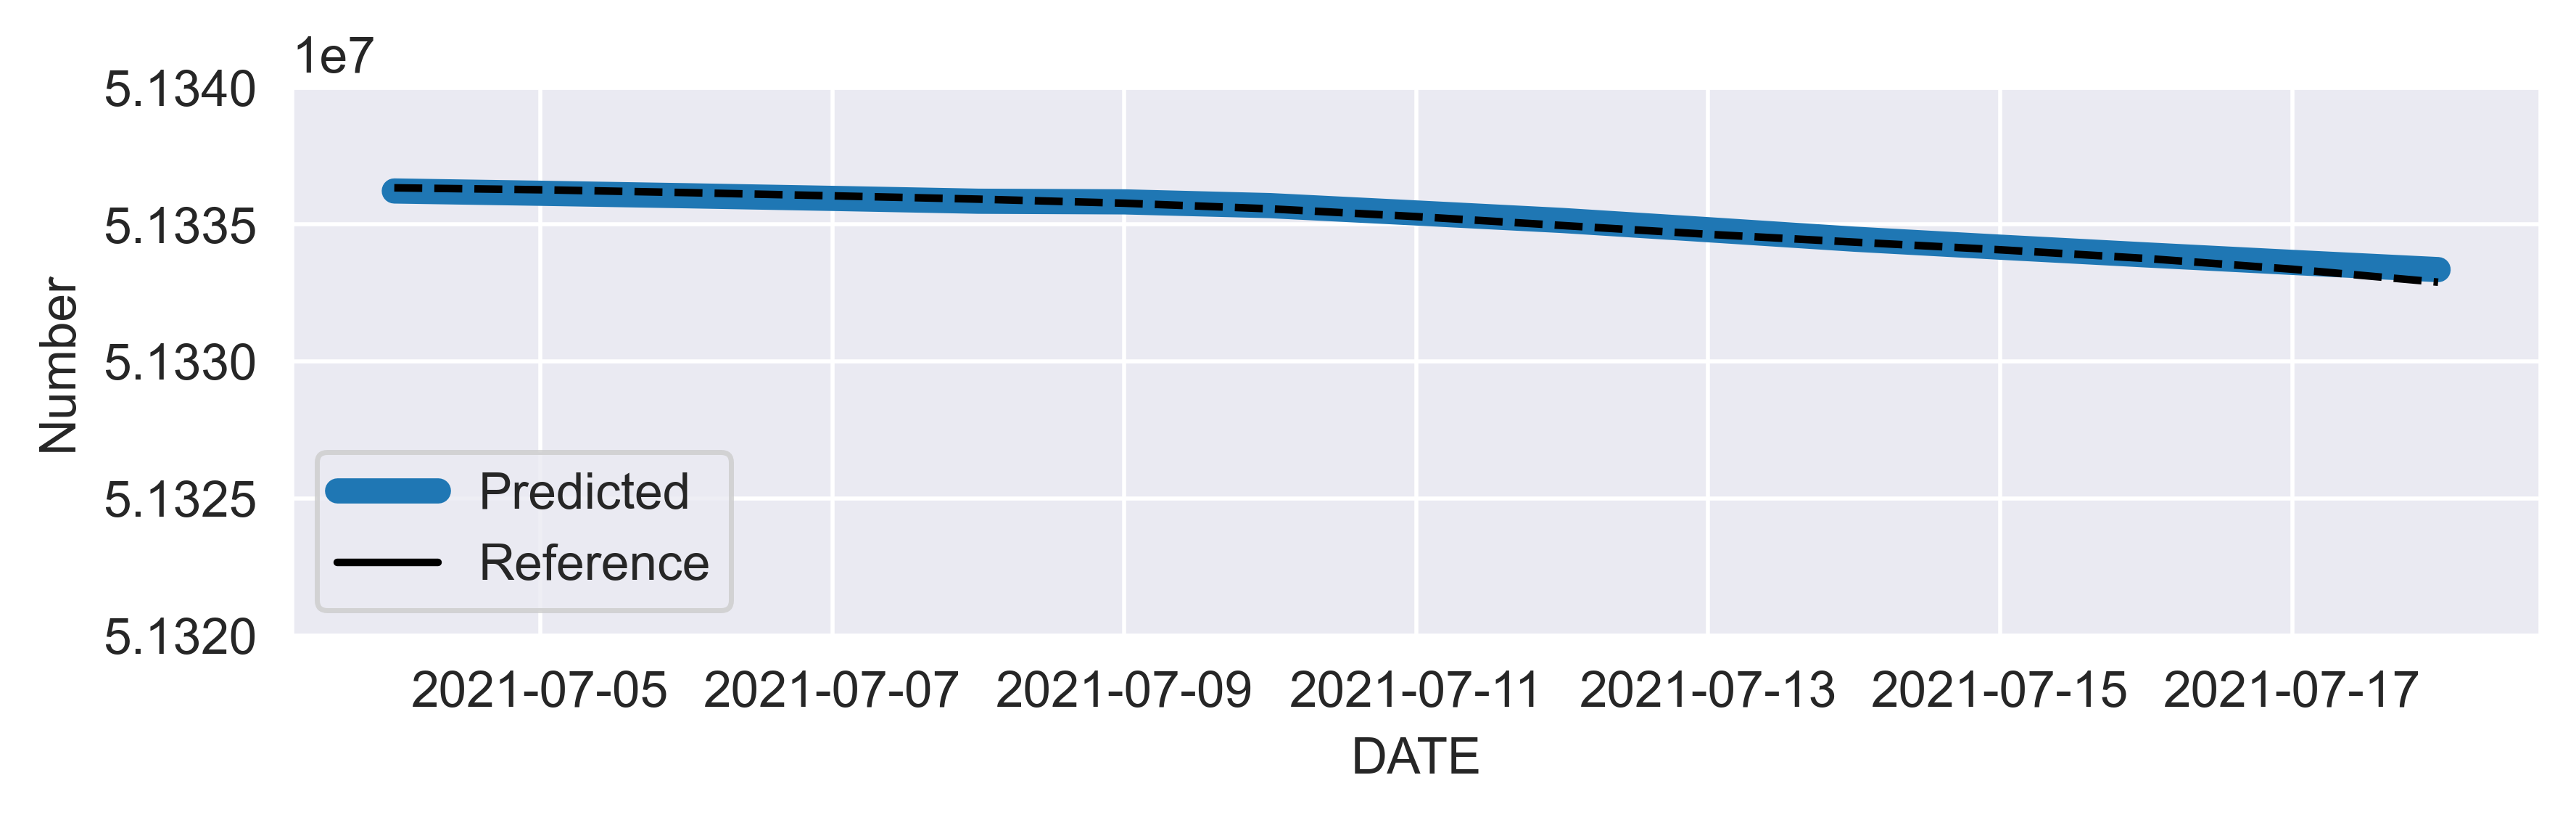

In [6]:
plt.figure(figsize=(8, 2),dpi=500) # width and height in inches
ax=sns.lineplot(data=df_est, x="DATE", y="S",palette="flare", label='Predicted',linewidth=5)
ax=sns.lineplot(data=df_ref, x="DATE", y="S", palette="flare",label='Reference',color='black')
ax.set_ylabel('Number')
#set line style
ax.lines[1].set_linestyle("--")
ax.set(ylim=(5.132e7,5.134e7))

[(200.0, 1500.0)]

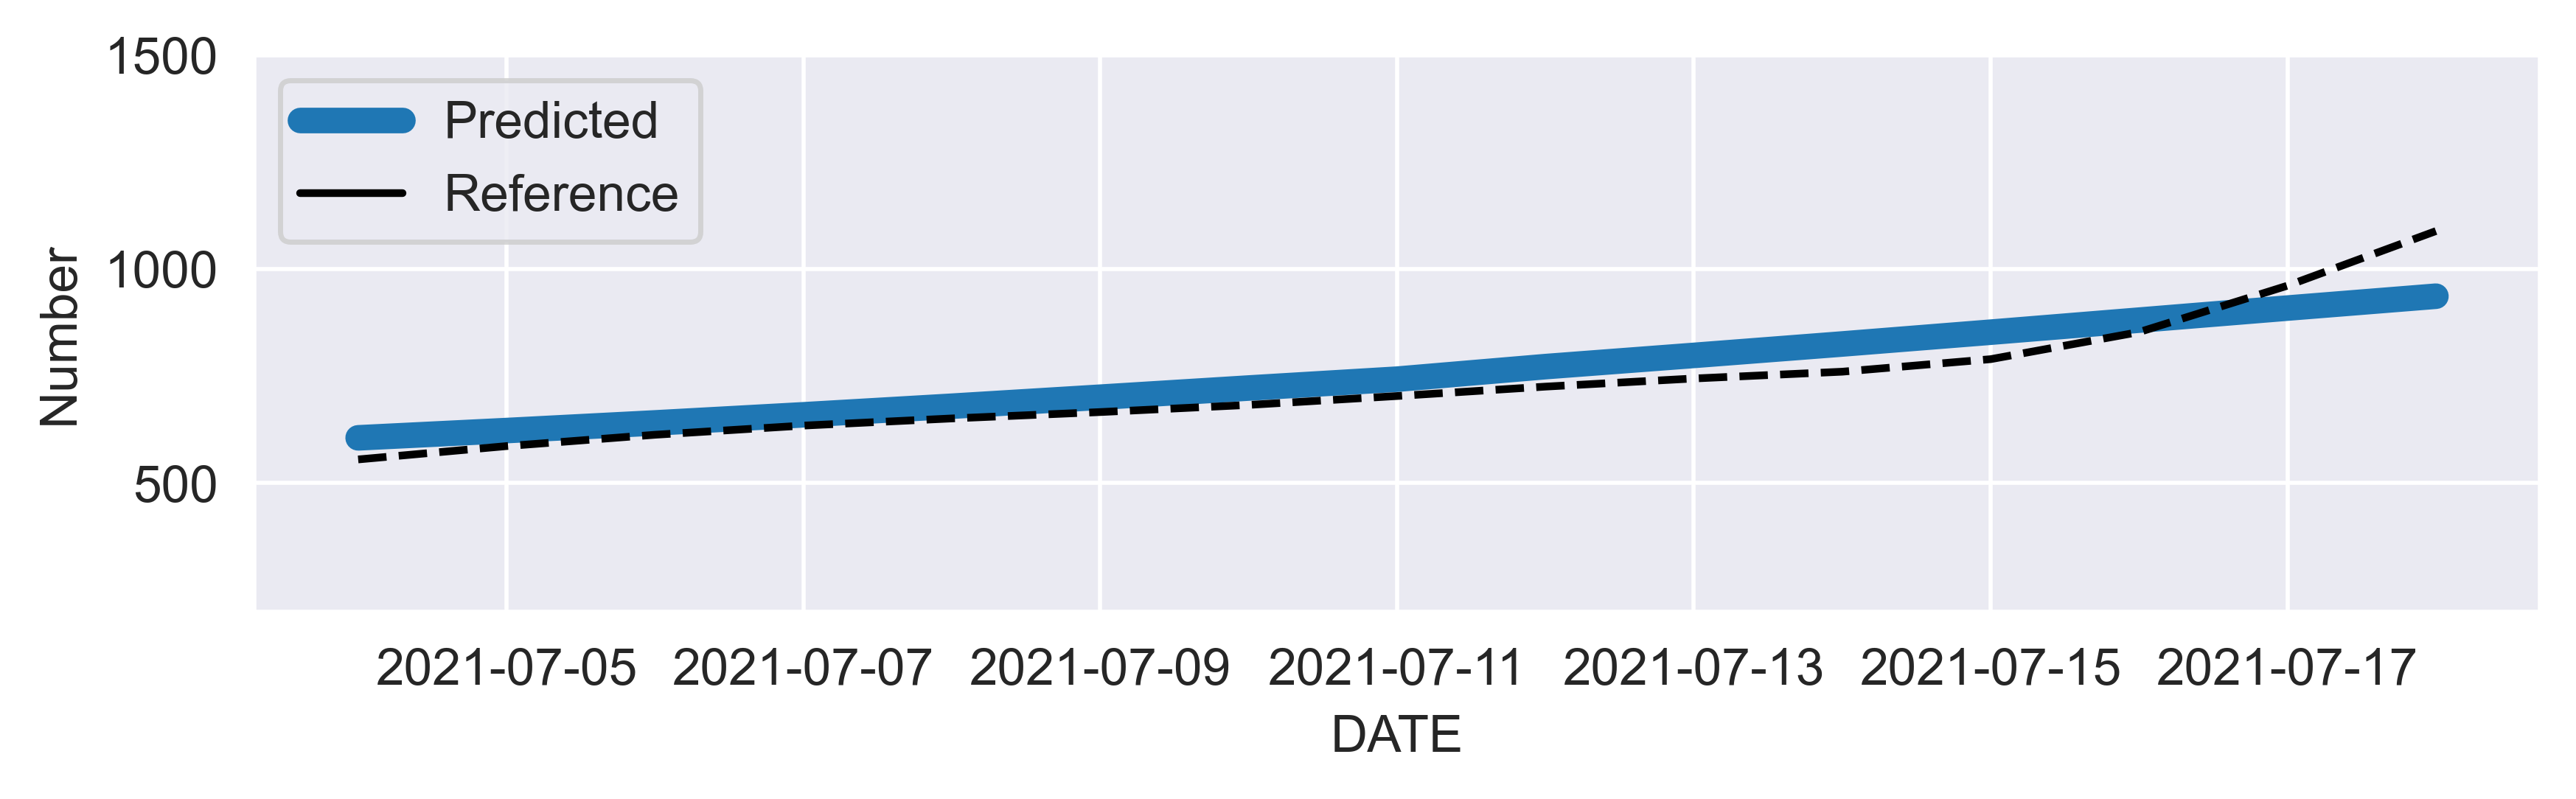

In [7]:
plt.figure(figsize=(8, 2),dpi=500) # width and height in inches
ax=sns.lineplot(data=df_est, x="DATE", y="I",palette="flare", label='Predicted',linewidth=5)
ax=sns.lineplot(data=df_ref, x="DATE", y="I", palette="flare",label='Reference',color='black')
ax.set_ylabel('Number')
#set line style
ax.lines[1].set_linestyle("--")
ax.set(ylim=(200,1500))

[(4000.0, 11000.0)]

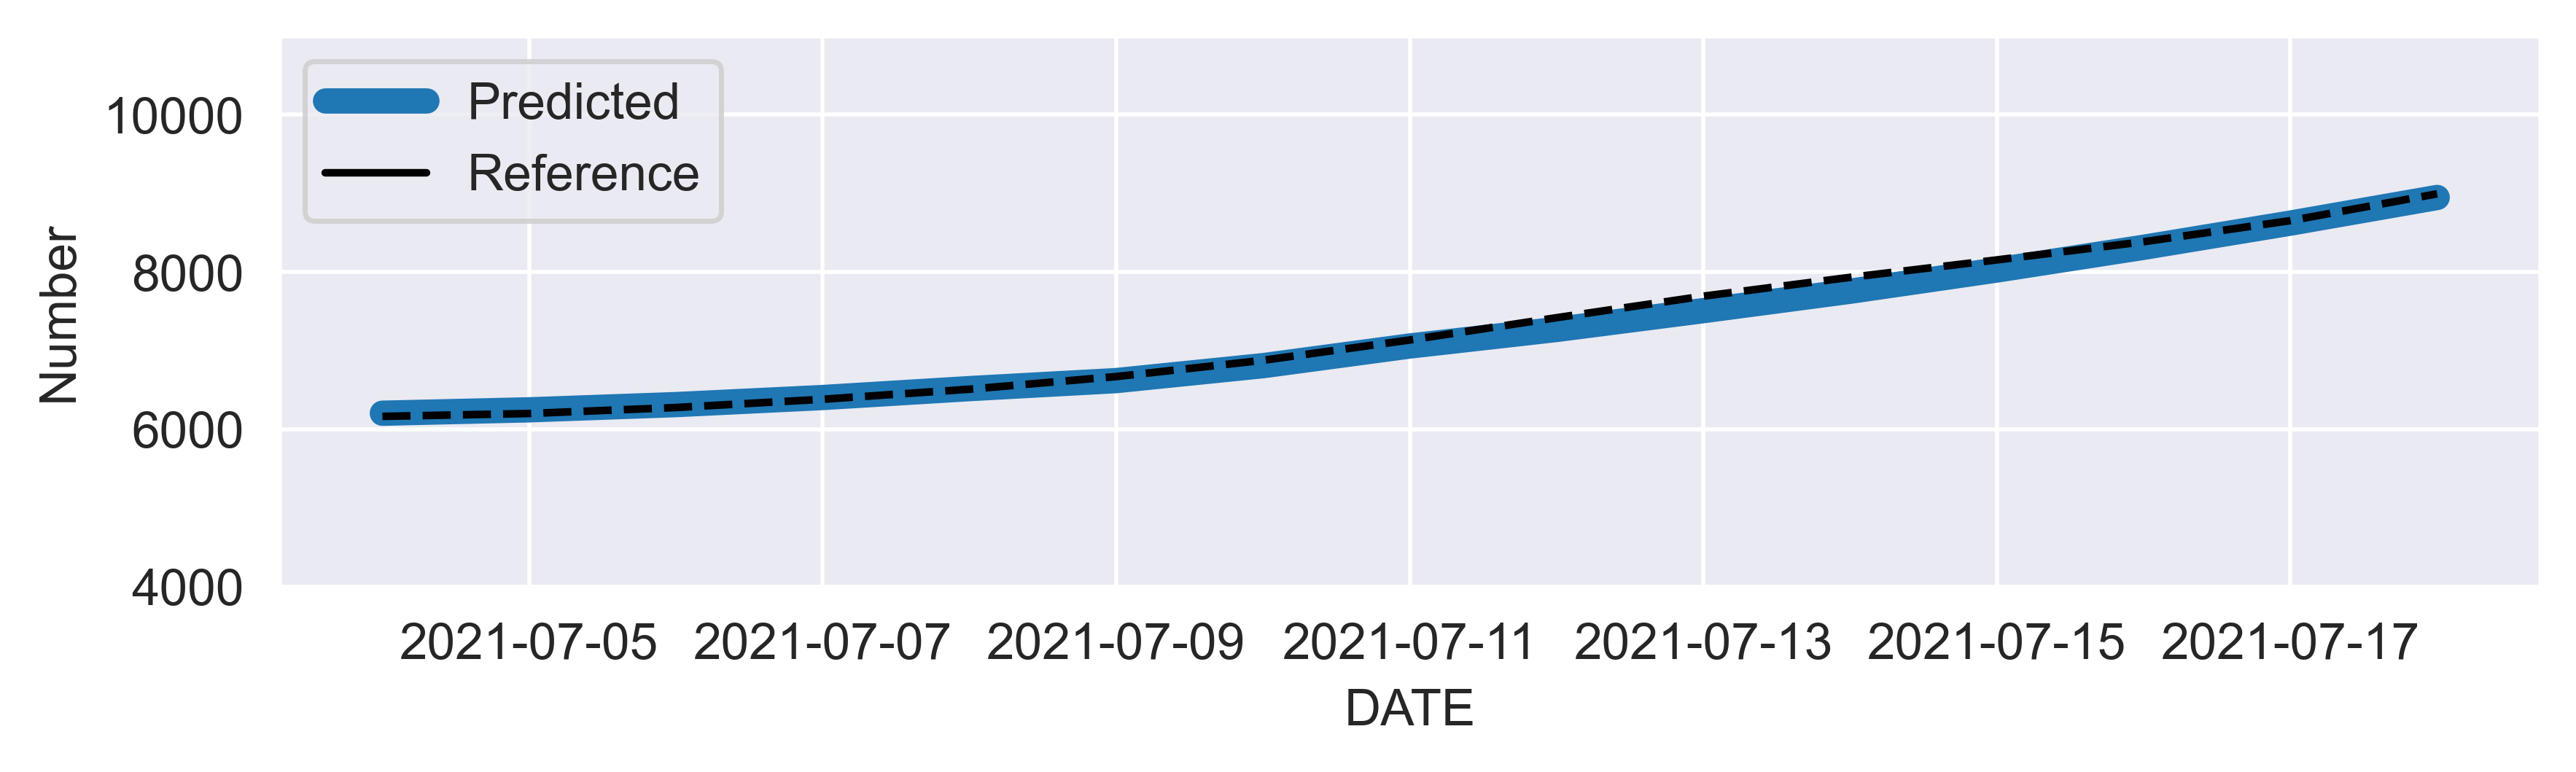

In [8]:
plt.figure(figsize=(8, 2),dpi=500) # width and height in inches
ax=sns.lineplot(data=df_est, x="DATE", y="Q",palette="flare", label='Predicted',linewidth=5)
ax=sns.lineplot(data=df_ref, x="DATE", y="Q", palette="flare",label='Reference',color='black')
ax.set_ylabel('Number')
#set line style
ax.lines[1].set_linestyle("--")
ax.set(ylim=(4000,11000))

[(100.0, 1000.0)]

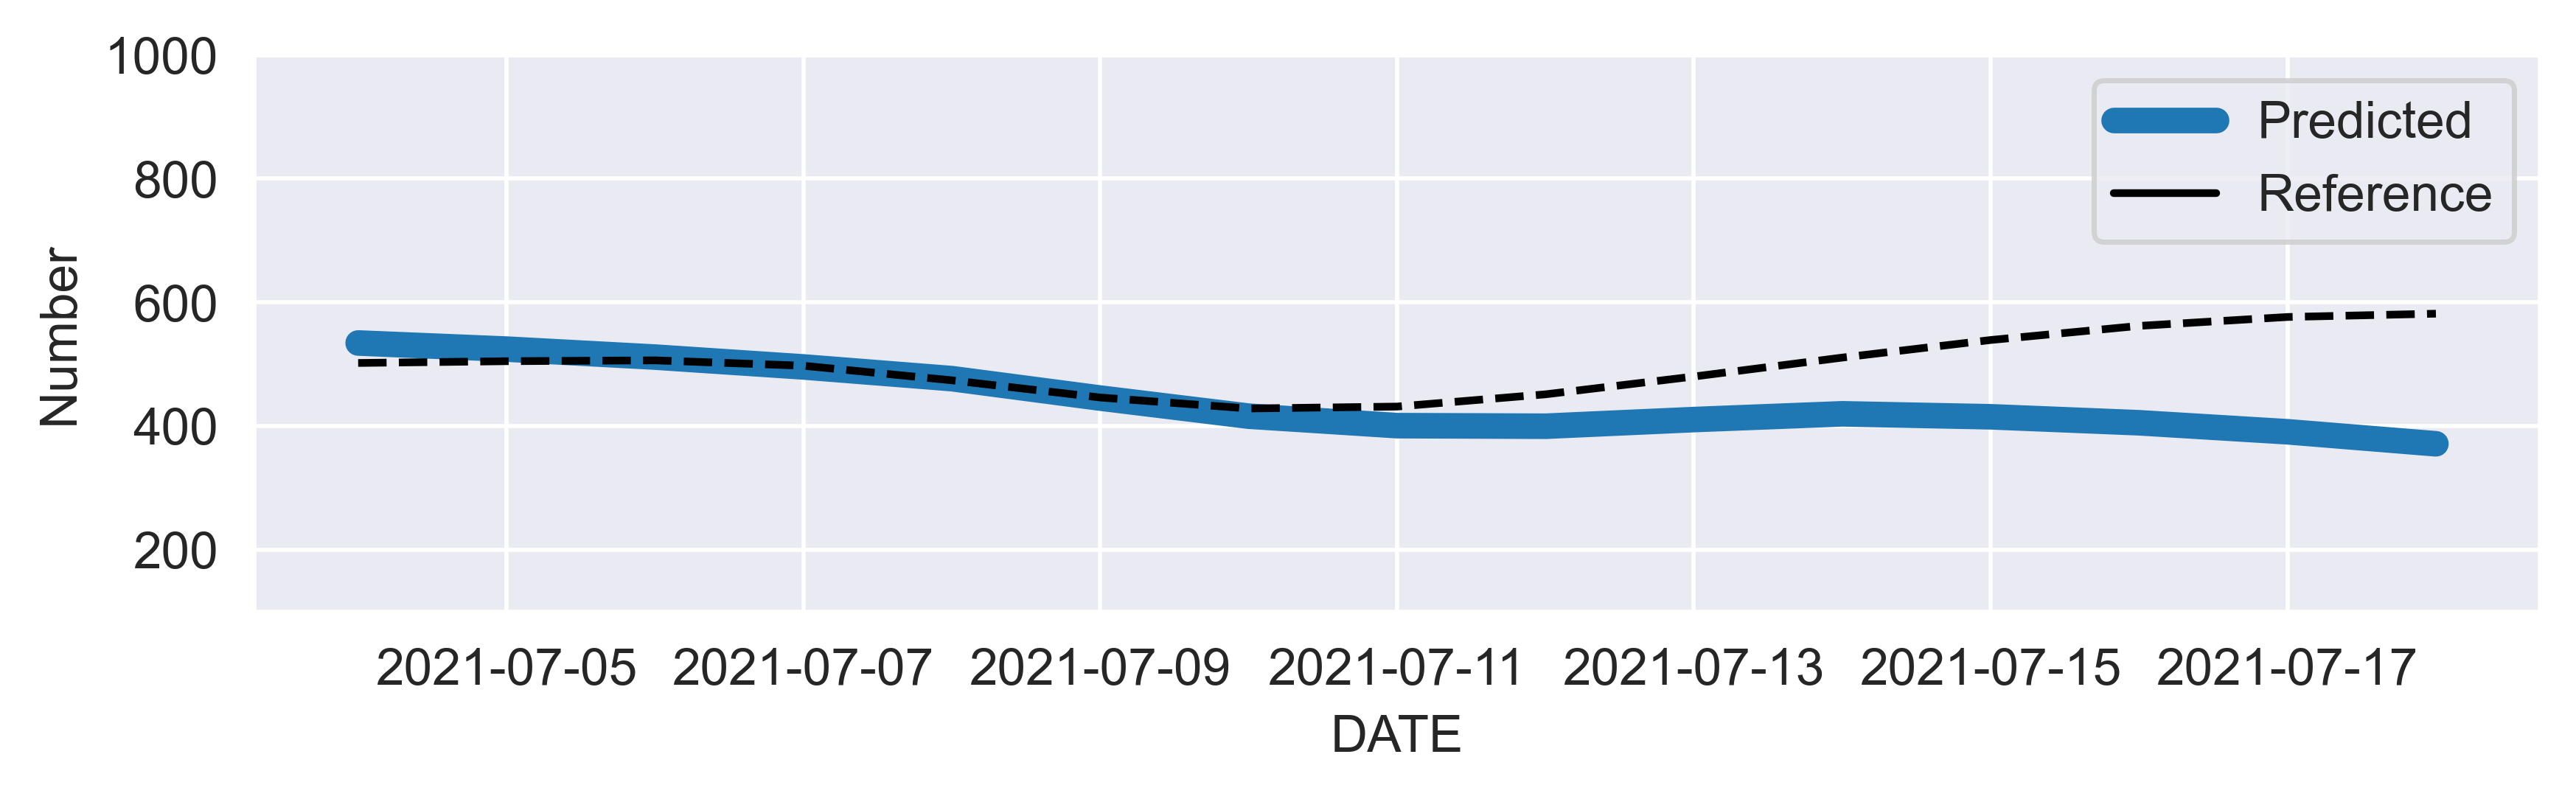

In [9]:
plt.figure(figsize=(8, 2),dpi=500) # width and height in inches
ax=sns.lineplot(data=df_est, x="DATE", y="R",palette="flare", label='Predicted',linewidth=5)
ax=sns.lineplot(data=df_ref, x="DATE", y="R", palette="flare",label='Reference',color='black')
ax.set_ylabel('Number')
#set line style
ax.lines[1].set_linestyle("--")
ax.set(ylim=(100,1000))

[(0.0, 10.0)]

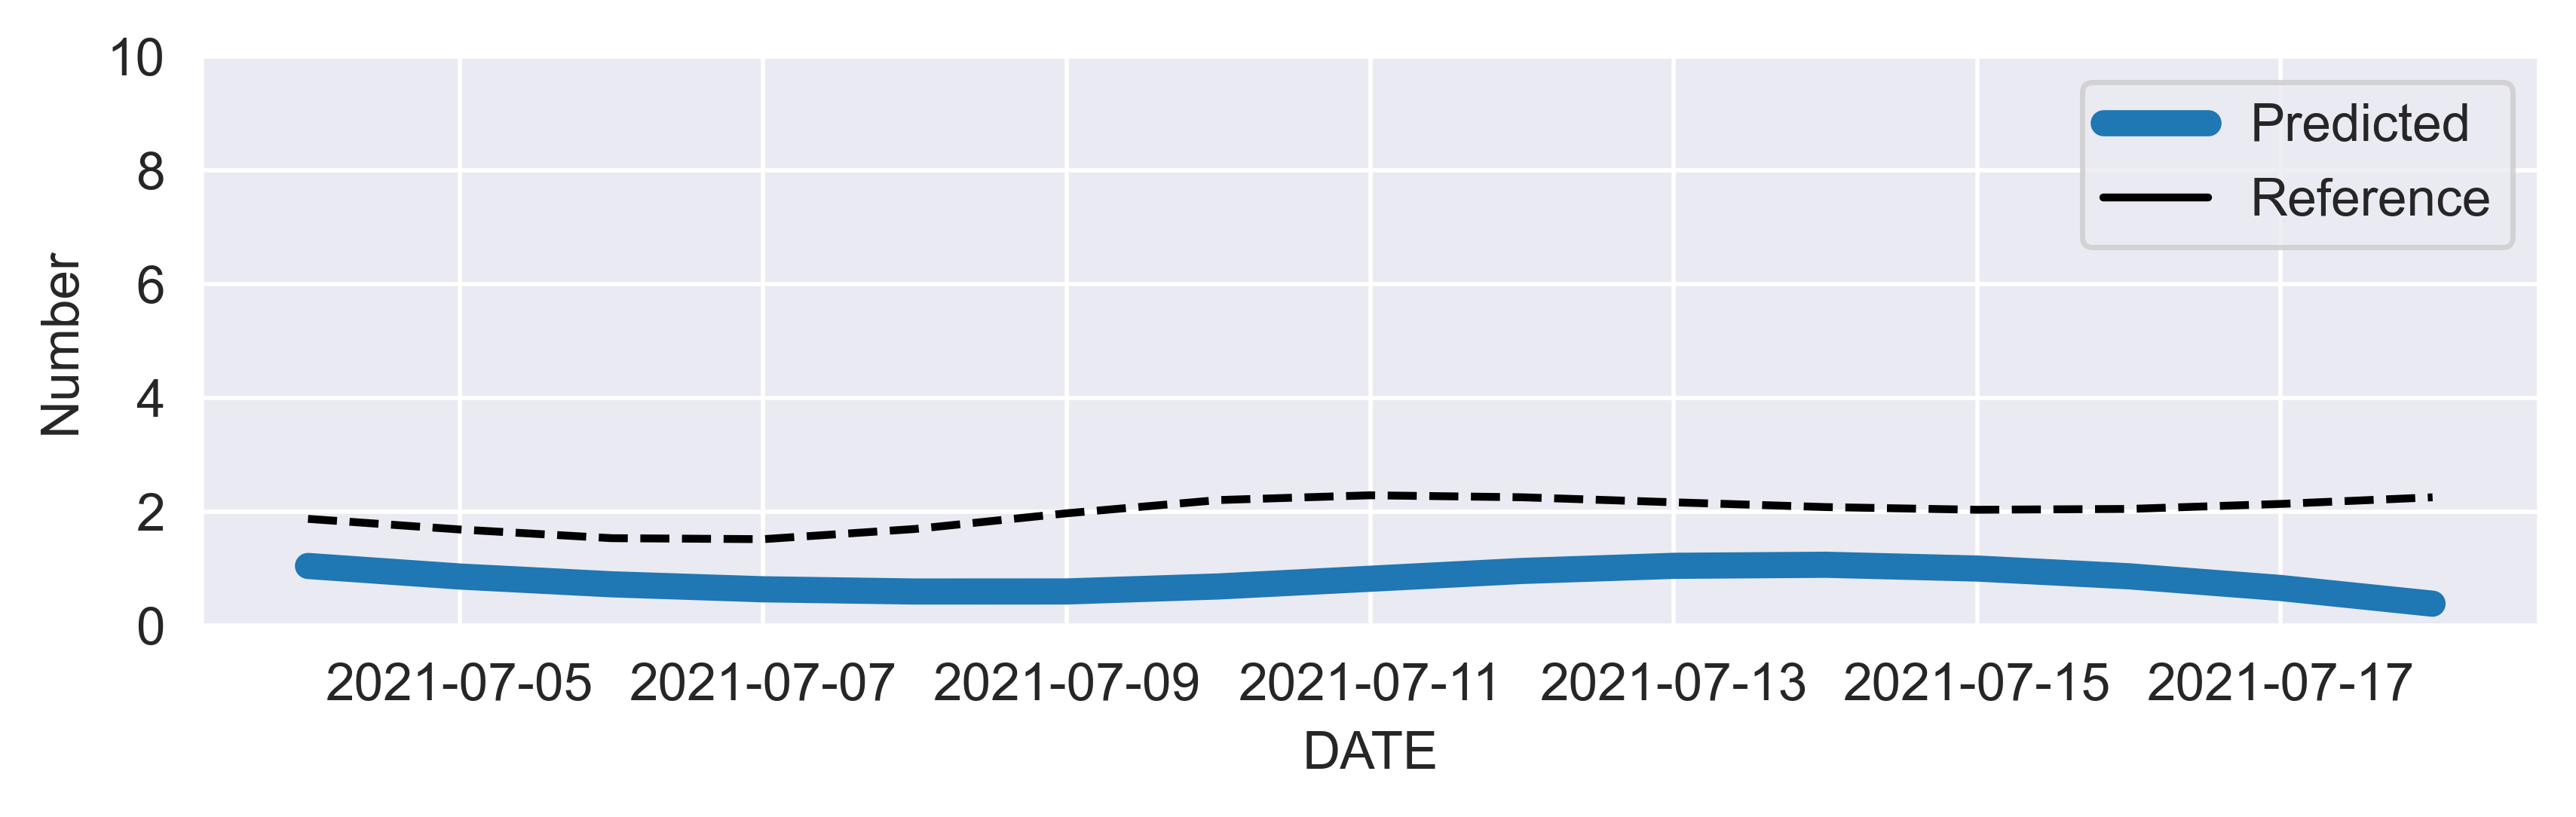

In [10]:
plt.figure(figsize=(8, 2),dpi=500) # width and height in inches
ax=sns.lineplot(data=df_est, x="DATE", y="D",palette="flare", label='Predicted',linewidth=5)
ax=sns.lineplot(data=df_ref, x="DATE", y="D", palette="flare",label='Reference',color='black')
ax.set_ylabel('Number')
#set line style
ax.lines[1].set_linestyle("--")
ax.set(ylim=(0,10))